In [24]:
# Download the dataset
import pandas as pd
import numpy as np
# Load data
ratings = pd.read_csv('D:/infotactml/ml-latest-small/ratings.csv')
movies = pd.read_csv('D:/infotactml/ml-latest-small/movies.csv')

# Preview
print(ratings.head())
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [25]:
# Merge ratings with movie titles
data = pd.merge(ratings, movies, on='movieId')

# Check for nulls
print(data.isnull().sum())

# Convert timestamp to datetime (optional)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Normalize ratings if needed (e.g., mean-centering per user)
rating_mean = data.groupby('userId')['rating'].transform('mean')
data['norm_rating'] = data['rating'] - rating_mean

data.head()


userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


,userId,movieId,rating,timestamp,title,genres,norm_rating
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-0.366379
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,-0.366379
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,-0.366379
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0.633621
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0.633621


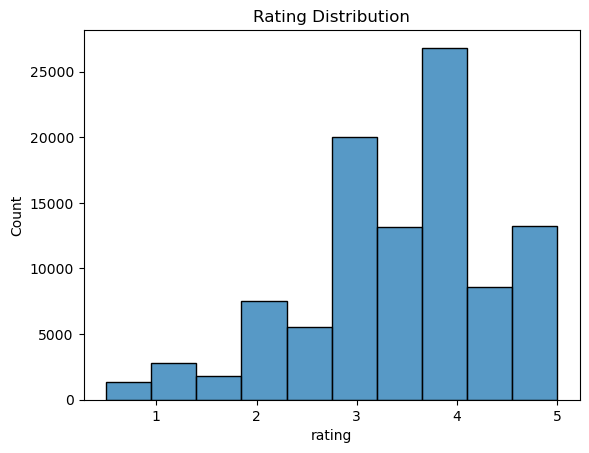

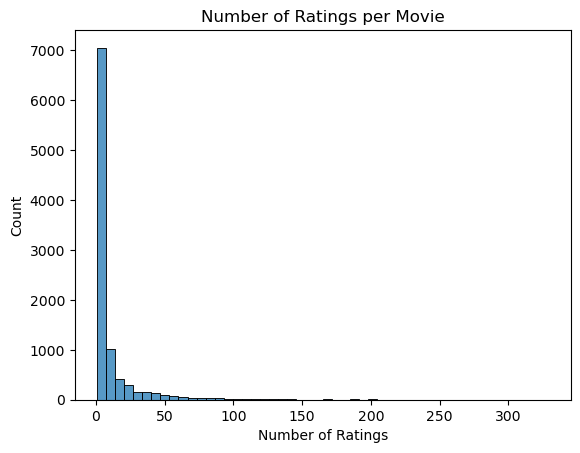

Sparsity: 98.30%


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
sns.histplot(data['rating'], bins=10)
plt.title("Rating Distribution")
plt.show()

# Number of ratings per movie
movie_counts = data['movieId'].value_counts()
sns.histplot(movie_counts, bins=50)
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.show()

# Sparsity
n_users = data['userId'].nunique()
n_movies = data['movieId'].nunique()
sparsity = 1 - len(data) / (n_users * n_movies)
print(f"Sparsity: {sparsity:.2%}")


In [27]:
# Create a user-item rating matrix
user_item_matrix = data.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_item_matrix)
item_similarity = cosine_similarity(user_item_matrix.T)

# Convert to DataFrame for readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

user_similarity_df.head(), item_similarity_df.head()


(userId       1         2         3         4         5         6         7    \
 userId                                                                         
 1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
 2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
 3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
 4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
 5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   
 
 userId       8         9         10   ...       601       602       603  \
 userId                                ...                                 
 1       0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
 2       0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
 3       0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
 4       0.062969  0.011361  0.031163  ...  0.08593

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

svd = TruncatedSVD(n_components=20)
matrix_reduced = svd.fit_transform(user_item_matrix)

approx_matrix = np.dot(matrix_reduced, svd.components_)

# Evaluate for a sample user
user_idx = 0
original = user_item_matrix.iloc[user_idx].values
predicted = approx_matrix[user_idx]
rmse = np.sqrt(mean_squared_error(original, predicted))
print(f"RMSE: {rmse:.4f}")


RMSE: 0.5590


In [29]:
def hybrid_recommend(user_id, user_item_matrix, approx_matrix, movie_titles, top_n=5):
    rated_movies = user_item_matrix.iloc[user_id]
    rated_indices = rated_movies[rated_movies > 0].index
    preds = approx_matrix[user_id]
    movie_scores = pd.Series(preds, index=user_item_matrix.columns)
    movie_scores = movie_scores.drop(labels=rated_indices)
    return movie_scores.sort_values(ascending=False).head(top_n)

# Example: Recommendations for user 0
print(hybrid_recommend(0, user_item_matrix, approx_matrix, user_item_matrix.columns))


title
Terminator 2: Judgment Day (1991)    4.005171
Aliens (1986)                        3.674414
Sixth Sense, The (1999)              3.350583
Breakfast Club, The (1985)           3.174516
Die Hard (1988)                      3.082006
dtype: float64


In [36]:
import streamlit as st

st.title("Movie Recommendation System")

user_id = st.number_input("Enter User ID", min_value=0, max_value=user_item_matrix.shape[0] - 1)

if st.button("Get Recommendations"):
    recs = hybrid_recommend(user_id, user_item_matrix, approx_matrix, user_item_matrix.columns)
    st.write("Top Recommendations:")
    st.write(recs)


2025-06-27 11:15:37.857 
  command:

    streamlit run C:\Users\Naidu\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-27 11:15:37.867 Session state does not function when running a script without `streamlit run`
